In [40]:
import torch
import torchvision
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)

minist_train = torchvision.datasets.MNIST(root='./data', train=True, 
                                          download=True, transform=transform)
minist_train_loader = torch.utils.data.DataLoader(minist_train, batch_size=4,
                                                  shuffle=True)

minist_test = torchvision.datasets.MNIST(root='./data', train=False, 
                                         download=True, transform=transform)
minist_test_loader = torch.utils.data.DataLoader(minist_test, batch_size=4, 
                                                 shuffle=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


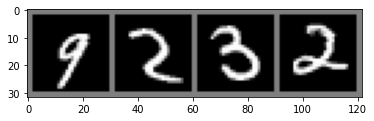



    9     2     3     2


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(minist_test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(4)))

In [36]:
from torch import nn
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
        
        self.net = nn.Sequential(
            nn.Conv2d(c, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * ((h - 4) // 2 - 4) * ((w - 4) // 2 - 4), 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    def forward(self, input):
        return self.net(input)

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [59]:
def train(model, train_loader, epoches, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for e in range(epoches):
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(tqdm(train_loader, desc= f'epoch {e}:')):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).float().mean().item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999: # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f, acc: %.3f' % 
                      (e + 1, i + 1, running_loss / 2000, running_acc / 2000))
                running_loss = 0.0
                running_acc = 0.0
    print('Finished Training')

def eval_acc(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(test_loader, desc= f'evaluating:')):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total

In [ ]:
import pathlib
models = []
pathlib.Path('MINST').mkdir(exist_ok=True)
for i in range(5):
    net = Net((1, 28, 28), 10)
    train(net, minist_train_loader, 2, nn.CrossEntropyLoss(),
        optim.Adam(net.parameters()))
    eval_acc(net, minist_test_loader)
    models.append(net)
    PATH = f'./MINST/net_{i}.pth'
    torch.save(net.state_dict(), PATH)

In [94]:
test_acc = []
for model in models:
    test_acc.append(eval_acc(model, minist_test_loader))  


In [89]:
class AverageEsemble(nn.Module):
    def __init__(self, models, output_dim):
        super().__init__()
        self.models = models
        self.output_dim = output_dim
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for model in self.models:
            model.eval()

    def forward(self, inputs):
        averages = torch.zeros(inputs.shape[0], self.output_dim).to(self.device)
        for model in self.models:
            outputs = model(inputs)
            probabilities = nn.functional.softmax(outputs, dim=1)
            averages += probabilities
        return averages / len(self.models)

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ensemble = AverageEsemble(models, 10)
test_acc.append(eval_acc(ensemble, minist_test_loader))

In [96]:
test_acc

[0.9778, 0.9844, 0.9823, 0.9797, 0.9828, 0.9913]

Text(0, 0.5, 'test acc')

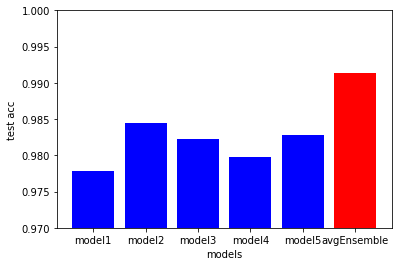

In [115]:
plt.bar(['model1', 'model2', 'model3', 'model4', 'model5', 'avgEnsemble'], 
        test_acc, color=['blue', 'blue', 'blue', 'blue', 'blue', 'red'])
plt.ylim(0.97, 1)
plt.xlabel('models')
plt.ylabel('test acc')

In [114]:
! zip -r models.zip MINST/

  adding: MINST/ (stored 0%)
  adding: MINST/net_1.pth (deflated 7%)
  adding: MINST/net_4.pth (deflated 7%)
  adding: MINST/net_3.pth (deflated 7%)
  adding: MINST/net_0.pth (deflated 7%)
  adding: MINST/net_2.pth (deflated 7%)


In [18]:
import torch
test = torch.rand(2,2)
print(test)
test[[0, 1], [1,1]]

tensor([[0.2225, 0.4496],
        [0.4222, 0.1307]])


tensor([0.4496, 0.1307])

In [10]:
torch.stack((list(zip(*batch))[0]))

tensor([[[0.4648, 0.2483],
         [0.4549, 0.6723]],

        [[0.2279, 0.6282],
         [0.2947, 0.1283]]])

In [5]:
list(zip(*batch))

[(tensor([[0.4648, 0.2483],
          [0.4549, 0.6723]]), tensor([[0.2279, 0.6282],
          [0.2947, 0.1283]])),
 (tensor([0.2578]), tensor([0.8618])),
 (tensor([0.7588]), tensor([0.4532]))]

In [12]:
torch.tensor([[1], [2]]).squeeze()

tensor([1, 2])